In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time

/home/dikatok/miniconda3/envs/deeplearning/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
STYLE_IMG = "../test_images/styles/stars2.jpg"
CONTENT_IMG = "../test_images/contents/venice-boat.jpg"

STYLE_DIR = "../styles/"
CONTENT_DIR = "../contents/"
VGG_WEIGHT = "../vgg16_weights.npz"
LOG_DIR = "./logs"
MODEL_DIR = "./models"
CKPT_DIR = "./ckpts"

NUM_EPOCHS = 2
LEARNING_RATE = 1e-3
CONTENT_BATCH_SIZE = 4
STYLE_BATCH_SIZE = 1
LOG_ITER = 100
SAMPLE_ITER = 100
STYLE_SIZE = 256
CONTENT_SIZE = 256

CONTENT_LOSS_WEIGHT = 1
STYLE_LOSS_WEIGHT = 5

In [3]:
def vgg16(x, weights):
    # substract imagenet mean
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='imagenet_mean')
    x = x - mean
    
    with tf.variable_scope("vgg16", reuse=tf.AUTO_REUSE):
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_1_W"]), trainable=False, name='conv1_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_1_b"]), trainable=False, name='conv1_1_b')
            conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_1 = tf.nn.bias_add(conv1_1, biases)
            conv1_1 = tf.nn.relu(conv1_1, name=scope)

        with tf.name_scope('conv1_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_2_W"]), trainable=False, name='conv1_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_2_b"]), trainable=False, name='conv1_2_b')
            conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_2 = tf.nn.bias_add(conv1_2, biases)
            conv1_2 = tf.nn.relu(conv1_2, name=scope)

        pool1 = tf.nn.avg_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
                               name='pool1')

        with tf.name_scope('conv2_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_1_W"]), trainable=False, name='conv2_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_1_b"]), trainable=False, name='conv2_1_b')
            conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_1 = tf.nn.bias_add(conv2_1, biases)
            conv2_1 = tf.nn.relu(conv2_1, name=scope)

        with tf.name_scope('conv2_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_2_W"]), trainable=False, name='conv2_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_2_b"]), trainable=False, name='conv2_2_b')
            conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_2 = tf.nn.bias_add(conv2_2, biases)
            conv2_2 = tf.nn.relu(conv2_2, name=scope)

        pool2 = tf.nn.avg_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool2')

        with tf.name_scope('conv3_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_1_W"]), trainable=False, name='conv3_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_1_b"]), trainable=False, name='conv3_1_b')
            conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_1 = tf.nn.bias_add(conv3_1, biases)
            conv3_1 = tf.nn.relu(conv3_1, name=scope)

        with tf.name_scope('conv3_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_2_W"]), trainable=False, name='conv3_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_2_b"]), trainable=False, name='conv3_2_b')
            conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_2 = tf.nn.bias_add(conv3_2, biases)
            conv3_2 = tf.nn.relu(conv3_2, name=scope)

        with tf.name_scope('conv3_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_3_W"]), trainable=False, name='conv3_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_3_b"]), trainable=False, name='conv3_3_b')
            conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_3 = tf.nn.bias_add(conv3_3, biases)
            conv3_3 = tf.nn.relu(conv3_3, name=scope)

        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool3')

        with tf.name_scope('conv4_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_1_W"]), trainable=False, name='conv4_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_1_b"]), trainable=False, name='conv4_1_b')
            conv4_1 = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_1 = tf.nn.bias_add(conv4_1, biases)
            conv4_1 = tf.nn.relu(conv4_1, name=scope)

        with tf.name_scope('conv4_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_2_W"]), trainable=False, name='conv4_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_2_b"]), trainable=False, name='conv4_2_b')
            conv4_2 = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_2 = tf.nn.bias_add(conv4_2, biases)
            conv4_2 = tf.nn.relu(conv4_2, name=scope)

        with tf.name_scope('conv4_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_3_W"]), trainable=False, name='conv4_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_3_b"]), trainable=False, name='conv4_3_b')
            conv4_3 = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_3 = tf.nn.bias_add(conv4_3, biases)
            conv4_3 = tf.nn.relu(conv4_3, name=scope)
            
    return conv1_2, conv2_2, conv3_3, conv4_3

In [29]:
def instance_norm(x, name, epsilon=1e-5, gamma=None, beta=None):
    with tf.variable_scope(name):
        if gamma is None: gamma = tf.get_variable(shape=x.shape[-1], name="gamma")
        if beta is None: beta = tf.get_variable(shape=x.shape[-1], name="beta")
        mean, var = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        x = tf.nn.batch_normalization(x, mean, var, beta, gamma, epsilon, name="norm")
    return x

def conv(x, name, filters, kernel_size, strides, norm=instance_norm, act=tf.nn.relu, norm_gamma=None,
         norm_beta=None):
    padding = kernel_size//2
    with tf.variable_scope(name):
        x = tf.pad(x, paddings=[[0,0],[padding,padding],[padding,padding],[0,0]], mode="REFLECT")
        x = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, name="conv")
        if norm is not None: x = norm(x, name="norm", gamma=norm_gamma, beta=norm_beta)
        if act is not None: x = act(x, name="act")
    return x

def residual_block(x, name, filters, kernel_size, norm_gamma1=None, norm_gamma2=None, norm_beta1=None, 
                   norm_beta2=None):
    with tf.variable_scope(name):
        residual = x
        x = conv(x, "conv1", filters, kernel_size, strides=1, norm_gamma=norm_gamma1, norm_beta=norm_beta1)
        x = conv(x, "conv2", filters, kernel_size, strides=1, act=None, norm_gamma=norm_gamma2, 
                 norm_beta=norm_beta2)
    return x + residual

def upsample(x, name, filters, kernel_size, strides, norm_gamma=None, norm_beta=None):
    inferred_shape = tf.shape(x)
    w, h = x.shape.as_list()[1] or inferred_shape[1], x.shape.as_list()[2] or inferred_shape[2]
    x = tf.image.resize_images(x, size=[w * strides, h * strides])
    x = conv(x, name, filters, kernel_size, strides=1, norm_gamma=norm_gamma, norm_beta=norm_beta)
    return x

def tnet(x, gammas, betas):   
    with tf.variable_scope("tnet", reuse=tf.AUTO_REUSE):
        conv1 = conv(x, "conv1", filters=32, kernel_size=9, strides=1, norm_gamma=gammas["conv1"],
                     norm_beta=betas["conv1"])
        conv2 = conv(conv1, "conv2", filters=64, kernel_size=3, strides=2, norm_gamma=gammas["conv2"],
                     norm_beta=betas["conv2"])
        conv3 = conv(conv2, "conv3", filters=128, kernel_size=3, strides=2, norm_gamma=gammas["conv3"],
                     norm_beta=betas["conv3"])
        res1 = residual_block(conv3, "res1", filters=128, kernel_size=3, norm_gamma1=gammas["res1_1"],
                              norm_gamma2=gammas["res1_2"], norm_beta1=betas["res1_1"], 
                              norm_beta2=betas["res1_2"])
        res2 = residual_block(res1, "res2", filters=128, kernel_size=3, norm_gamma1=gammas["res2_1"],
                              norm_gamma2=gammas["res2_2"], norm_beta1=betas["res2_1"], 
                              norm_beta2=betas["res2_2"])
        res3 = residual_block(res2, "res3", filters=128, kernel_size=3, norm_gamma1=gammas["res3_1"],
                              norm_gamma2=gammas["res3_2"], norm_beta1=betas["res3_1"], 
                              norm_beta2=betas["res3_2"])
        res4 = residual_block(res3, "res4", filters=128, kernel_size=3, norm_gamma1=gammas["res4_1"],
                              norm_gamma2=gammas["res4_2"], norm_beta1=betas["res4_1"], 
                              norm_beta2=betas["res4_2"])
        res5 = residual_block(res4, "res5", filters=128, kernel_size=3, norm_gamma1=gammas["res5_1"],
                              norm_gamma2=gammas["res5_2"], norm_beta1=betas["res5_1"], 
                              norm_beta2=betas["res5_2"])
        up1 = upsample(res5, "up1", filters=64, kernel_size=3, strides=2, norm_gamma=gammas["up1"],
                       norm_beta=betas["up1"])
        up2 = upsample(up1, "up2", filters=32, kernel_size=3, strides=2, norm_gamma=gammas["up2"],
                       norm_beta=betas["up2"])
        conv4 = conv(up2, "conv4", filters=3, kernel_size=9, strides=1, norm=None, act=None)
    return tf.clip_by_value(conv4, 0., 255.)

def pnet_residual_block(x, name, filters, kernel_size):
    with tf.variable_scope(name):
        residual = x
        conv1 = conv(x, "conv1", filters, kernel_size, strides=1)
        conv2 = conv(conv1, "conv2", filters, kernel_size, strides=1)
    return conv2 + residual, conv1, conv2

def pnet_fc(x, name):
    shape = x.shape.as_list()
    with tf.variable_scope(name):
        x = tf.reshape(x, shape=[-1, shape[3]])
        shape = x.shape.as_list()
        w = tf.get_variable(shape=[1, shape[0]], name="w")
        b = tf.get_variable(shape=[1, shape[1]], name="b")
        fc = tf.squeeze(w @ x + b)
    return fc

def pnet(x): 
    gammas, betas = {}, {}
    with tf.variable_scope("pnet", reuse=tf.AUTO_REUSE):
        conv1 = conv(x, "conv1", filters=32, kernel_size=9, strides=1)
        gammas["conv1"], betas["conv1"] = pnet_fc(conv1, "fc_gamma_conv1"), pnet_fc(conv1, "fc_beta_conv1")
        
        conv2 = conv(conv1, "conv2", filters=64, kernel_size=3, strides=2)
        gammas["conv2"], betas["conv2"] = pnet_fc(conv2, "fc_gamma_conv2"), pnet_fc(conv2, "fc_beta_conv2")
        
        conv3 = conv(conv2, "conv3", filters=128, kernel_size=3, strides=2)
        gammas["conv3"], betas["conv3"] = pnet_fc(conv3, "fc_gamma_conv3"), pnet_fc(conv3, "fc_beta_conv3")
        
        res1, res1_1, res1_2 = pnet_residual_block(conv3, "res1", filters=128, kernel_size=3)
        gammas["res1_1"], betas["res1_1"] = pnet_fc(res1_1, "fc_gamma_res1_1"), pnet_fc(res1_1, "fc_beta_res1_1")
        gammas["res1_2"], betas["res1_2"] = pnet_fc(res1_2, "fc_gamma_res1_2"), pnet_fc(res1_2, "fc_beta_res1_2")
        
        res2, res2_1, res2_2 = pnet_residual_block(res1, "res2", filters=128, kernel_size=3)
        gammas["res2_1"], betas["res2_1"] = pnet_fc(res2_1, "fc_gamma_res2_1"), pnet_fc(res2_1, "fc_beta_res2_1")
        gammas["res2_2"], betas["res2_2"] = pnet_fc(res2_2, "fc_gamma_res2_2"), pnet_fc(res2_2, "fc_beta_res2_2")
        
        res3, res3_1, res3_2 = pnet_residual_block(res2, "res3", filters=128, kernel_size=3)
        gammas["res3_1"], betas["res3_1"] = pnet_fc(res3_1, "fc_gamma_res3_1"), pnet_fc(res3_1, "fc_beta_res3_1")
        gammas["res3_2"], betas["res3_2"] = pnet_fc(res3_2, "fc_gamma_res3_2"), pnet_fc(res3_2, "fc_beta_res3_2")
        
        res4, res4_1, res4_2 = pnet_residual_block(res3, "res4", filters=128, kernel_size=3)
        gammas["res4_1"], betas["res4_1"] = pnet_fc(res4_1, "fc_gamma_res4_1"), pnet_fc(res4_1, "fc_beta_res4_1")
        gammas["res4_2"], betas["res4_2"] = pnet_fc(res4_2, "fc_gamma_res4_2"), pnet_fc(res4_2, "fc_beta_res4_2")
        
        res5, res5_1, res5_2 = pnet_residual_block(res4, "res5", filters=128, kernel_size=3)
        gammas["res5_1"], betas["res5_1"] = pnet_fc(res5_1, "fc_gamma_res5_1"), pnet_fc(res5_1, "fc_beta_res5_1")
        gammas["res5_2"], betas["res5_2"] = pnet_fc(res5_2, "fc_gamma_res5_2"), pnet_fc(res5_2, "fc_beta_res5_2")
        
        up1 = upsample(res5, "up1", filters=64, kernel_size=3, strides=2)
        gammas["up1"], betas["up1"] = pnet_fc(up1, "fc_gamma_up1"), pnet_fc(up1, "fc_beta_up1")
        
        up2 = upsample(up1, "up2", filters=32, kernel_size=3, strides=2)
        gammas["up2"], betas["up2"] = pnet_fc(up2, "fc_gamma_up2"), pnet_fc(up2, "fc_beta_up2")
    return gammas, betas

In [5]:
def gram_matrix(x):
    batch_size, w, h, ch = x.shape.as_list()
    x = tf.reshape(x, [batch_size, w * h, ch])
    return tf.matmul(x, x, transpose_a=True) / (ch * w * h)

def loss_fun(target_style_features, target_content_features, transferred_features, transferred,
             style_loss_weight=STYLE_LOSS_WEIGHT, content_loss_weight=CONTENT_LOSS_WEIGHT):
    content_loss = tf.reduce_mean(tf.subtract(transferred_features[1], target_content_features[1]) ** 2, 
                                  [1, 2, 3])  

    style_loss = 0
    for i in range(len(transferred_features)):
        gram_target = gram_matrix(target_style_features[i])
        gram_transferred = gram_matrix(transferred_features[i])
        style_loss += tf.reduce_mean(tf.subtract(gram_target, gram_transferred) ** 2, [1, 2])  
        
    return tf.reduce_mean(content_loss_weight * content_loss 
                          + style_loss_weight * style_loss
                          + 1e-5 * tf.image.total_variation(transferred))

In [6]:
iterator = tf.keras.preprocessing.image.DirectoryIterator
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
content_iter = iterator(directory=CONTENT_DIR, batch_size=CONTENT_BATCH_SIZE, 
                        target_size=(CONTENT_SIZE,CONTENT_SIZE), image_data_generator=datagen, shuffle=True)
style_iter = iterator(directory=STYLE_DIR, batch_size=STYLE_BATCH_SIZE,
                      target_size=(STYLE_SIZE,STYLE_SIZE), image_data_generator=datagen)

Found 82783 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


In [7]:
if os.path.exists(CKPT_DIR):
    shutil.rmtree(CKPT_DIR)
    
vgg_weights = np.load(VGG_WEIGHT)

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

total_iteration = NUM_EPOCHS * content_iter.n // CONTENT_BATCH_SIZE

training_graph = tf.Graph()

with training_graph.as_default() as g, tf.Session(config=config, graph=training_graph) as sess:    
    style = tf.placeholder(name="style", dtype=tf.float32, 
                           shape=[STYLE_BATCH_SIZE,STYLE_SIZE,STYLE_SIZE,3])
    content = tf.placeholder(name="content", dtype=tf.float32, 
                             shape=[CONTENT_BATCH_SIZE,CONTENT_SIZE,CONTENT_SIZE,3])

    target_style_features = vgg16(style, vgg_weights)
    target_content_features = vgg16(content, vgg_weights)
    gammas, betas = pnet(style)
    transferred = tnet(content, gammas, betas)
    transferred_features = vgg16(transferred, vgg_weights)
    loss = loss_fun(target_style_features, target_content_features, transferred_features, transferred)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

    summary = tf.summary.FileWriter(graph=g, logdir=LOG_DIR)
    style_summary = tf.summary.image("style", style)
    content_summary = tf.summary.image("content", content)
    transferred_summary = tf.summary.image("transferred", transferred)
    image_summary = tf.summary.merge([style_summary, content_summary, transferred_summary])
    loss_summary = tf.summary.scalar("loss", loss)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(var_list=tf.trainable_variables())

    start = time.time()
    it = 0
    for i in range(NUM_EPOCHS):
        content_iter.reset()
        style_iter.reset()
        for c, _ in content_iter:
            it += 1
            
            if c.shape[0] < CONTENT_BATCH_SIZE:
                break
                 
            try:
                s, _ = style_iter.next()
            except StopIteration:
                style_iter.reset()
                s, _ = style_iter.next()
                    
            _, cur_loss, cur_loss_summary, cur_image_summary = sess.run([train_op, loss, loss_summary, 
                                                                         image_summary], 
                                                                        feed_dict={style: s, content: c})
            summary.add_summary(cur_loss_summary, it)

            if it % LOG_ITER == 0 or it == total_iteration:
                print("Iteration: [{it}/{num_iter}], loss: {loss}".format(it=it, num_iter=total_iteration,
                                                                          loss=cur_loss))
                
            if it % SAMPLE_ITER == 0 or it == total_iteration:
                summary.add_summary(cur_image_summary, it)
                
            summary.flush()
            
        ckpt_path = saver.save(sess, save_path=os.path.join(CKPT_DIR, "ckpt"), write_meta_graph=False, 
                               global_step=it)
        print("Checkpoint saved as: {ckpt_path}".format(ckpt_path=ckpt_path))
        
end = time.time()
print("Finished {num_iter} in {time} seconds".format(num_iter=total_iteration, time=end-start))

Iteration: [100/41391], loss: 7412152.0
Iteration: [200/41391], loss: 4424158.5
Iteration: [300/41391], loss: 3153929.25
Iteration: [400/41391], loss: 1659758.5
Iteration: [500/41391], loss: 783333.875
Iteration: [600/41391], loss: 695329.25
Iteration: [700/41391], loss: 1221544.0
Iteration: [800/41391], loss: 1304460.0
Iteration: [900/41391], loss: 876883.6875
Iteration: [1000/41391], loss: 4162529.75
Iteration: [1100/41391], loss: 2158170.25
Iteration: [1200/41391], loss: 810619.875
Iteration: [1300/41391], loss: 522986.1875
Iteration: [1400/41391], loss: 600565.125
Iteration: [1500/41391], loss: 1739270.875
Iteration: [1600/41391], loss: 1926515.0
Iteration: [1700/41391], loss: 658953.125
Iteration: [1800/41391], loss: 962973.0625
Iteration: [1900/41391], loss: 1394294.125
Iteration: [2000/41391], loss: 1093969.875
Iteration: [2100/41391], loss: 391202.4375
Iteration: [2200/41391], loss: 247925.0625
Iteration: [2300/41391], loss: 687098.125
Iteration: [2400/41391], loss: 553156.5
It

Iteration: [19200/41391], loss: 238166.375
Iteration: [19300/41391], loss: 440259.59375
Iteration: [19400/41391], loss: 253386.921875
Iteration: [19500/41391], loss: 338964.15625
Iteration: [19600/41391], loss: 450278.9375
Iteration: [19700/41391], loss: 264721.84375
Iteration: [19800/41391], loss: 227719.125
Iteration: [19900/41391], loss: 578683.125
Iteration: [20000/41391], loss: 472709.65625
Iteration: [20100/41391], loss: 611472.125
Iteration: [20200/41391], loss: 578732.625
Iteration: [20300/41391], loss: 356093.0
Iteration: [20400/41391], loss: 598746.25
Iteration: [20500/41391], loss: 555825.875
Iteration: [20600/41391], loss: 362038.15625
Checkpoint saved as: ./ckpts/ckpt-20696
Iteration: [20700/41391], loss: 408539.40625
Iteration: [20800/41391], loss: 212882.03125
Iteration: [20900/41391], loss: 455399.46875
Iteration: [21000/41391], loss: 468511.625
Iteration: [21100/41391], loss: 333668.0
Iteration: [21200/41391], loss: 430051.5
Iteration: [21300/41391], loss: 279699.4375


Iteration: [37800/41391], loss: 386780.25
Iteration: [37900/41391], loss: 331269.59375
Iteration: [38000/41391], loss: 335103.625
Iteration: [38100/41391], loss: 353563.1875
Iteration: [38200/41391], loss: 392869.1875
Iteration: [38300/41391], loss: 212632.828125
Iteration: [38400/41391], loss: 180174.59375
Iteration: [38500/41391], loss: 208992.0
Iteration: [38600/41391], loss: 229489.46875
Iteration: [38700/41391], loss: 239987.453125
Iteration: [38800/41391], loss: 90940.125
Iteration: [38900/41391], loss: 348981.65625
Iteration: [39000/41391], loss: 294894.15625
Iteration: [39100/41391], loss: 92886.53125
Iteration: [39200/41391], loss: 97399.3828125
Iteration: [39300/41391], loss: 321034.0625
Iteration: [39400/41391], loss: 259251.375
Iteration: [39500/41391], loss: 190472.296875
Iteration: [39600/41391], loss: 300866.4375
Iteration: [39700/41391], loss: 289711.9375
Iteration: [39800/41391], loss: 212156.1875
Iteration: [39900/41391], loss: 233260.71875
Iteration: [40000/41391], l

In [30]:
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)

tf.reset_default_graph()

eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
exporter = tf.saved_model.builder.SavedModelBuilder(MODEL_DIR)
latest_ckpt = tf.train.latest_checkpoint(CKPT_DIR)

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:   
    inputs_signature, outputs_signature = {}, {}
    
    style = inputs_signature["style"] = tf.placeholder(name="style", dtype=tf.float32, 
                                                       shape=[1,STYLE_SIZE,STYLE_SIZE,3])
    inputs = inputs_signature["inputs"] = tf.placeholder(name="inputs", dtype=tf.float32, 
                                                         shape=[None,None,None,3])
    
    gammas, betas = pnet(style)
    
    gammas_in, betas_in = {}, {}
    for key in gammas.keys():
        outputs_signature["gammas_out_{key}".format(key=key)] \
            = tf.identity(gammas[key], name="gammas_out_{key}".format(key=key))
        outputs_signature["betas_out_{key}".format(key=key)] \
            = tf.identity(betas[key], name="betas_out_{key}".format(key=key))
        inputs_signature["gammas_in_{key}".format(key=key)] = gammas_in[key] \
            = tf.placeholder(name="gammas_in_{key}".format(key=key), dtype=tf.float32, 
                             shape=gammas[key].shape)
        inputs_signature["betas_in_{key}".format(key=key)] = betas_in[key] \
            = tf.placeholder(name="betas_in_{key}".format(key=key), dtype=tf.float32, 
                             shape=betas[key].shape)
        
    outputs_signature["outputs"] = tf.identity(tnet(inputs, gammas_in, betas_in), name="outputs")
    
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt)
    
    exporter.add_meta_graph_and_variables(
        sess, 
        tags=[tf.saved_model.tag_constants.SERVING], 
        signature_def_map={
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            tf.saved_model.signature_def_utils.predict_signature_def(inputs=inputs_signature, 
                                                                     outputs=outputs_signature)
        })
    exporter.save()

INFO:tensorflow:Restoring parameters from ./ckpts/ckpt-41392
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./models/saved_model.pb'


INFO:tensorflow:Restoring parameters from b'./models/variables/variables'
Inference time: 0.19213366508483887 seconds


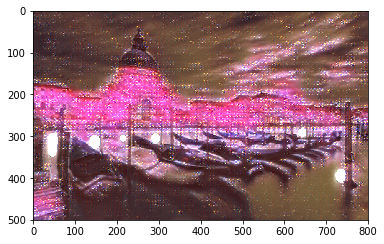

In [51]:
content_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(CONTENT_IMG))
style_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(STYLE_IMG, target_size=(STYLE_SIZE,STYLE_SIZE)))

tf.reset_default_graph()
eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:  
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], MODEL_DIR)
    
    c, s = sess.run([tf.expand_dims(content_image, axis=0), tf.expand_dims(style_image, axis=0)])
    
    inputs = g.get_tensor_by_name("inputs:0")
    style = g.get_tensor_by_name("style:0")
    outputs = g.get_tensor_by_name("outputs:0")  
    
    pnet_out = {}
    for op in tf.get_default_graph().get_operations():
        if op.name.startswith("gammas_out") or op.name.startswith("betas_out"):
            pnet_out[op.name.replace("out", "in")] = g.get_tensor_by_name(op.name + ":0")
                                     
    pnet_out_list = sess.run([op for _, op in pnet_out.items()], feed_dict={style: s})
    
    tnet_in = {inputs: c}
    i = 0
    for op_name in pnet_out.keys():
        tnet_in[g.get_tensor_by_name(op_name.replace("out", "in") + ":0")] = pnet_out_list[i]
        i += 1
                
    start = time.time()
    result = sess.run(tf.squeeze(outputs), feed_dict=tnet_in)
    end = time.time()
    print("Inference time: {time} seconds".format(time=end-start))
    
plt.imshow(result / 255.)    
plt.show()